In [ ]:
#!/usr/bin/env python
import tensorflow as tf
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage.transform import radon, iradon
from skimage.measure import compare_ssim
import math
from google.colab import drive    # in ordre to mount drive to colab
drive.mount('/content/gdrive')

gpu_options = tf.GPUOptions(allow_growth=True)
session_config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options, allow_soft_placement=True)
sess = tf.Session(config=session_config)

pi = tf.constant(math.pi, tf.float32)
sinogram_height = 512
views = 49
theta = np.linspace(0, 360, views, endpoint=False)
T = tf.convert_to_tensor(theta)
T = tf.cast(T, tf.float32)
batch_size = 1
learning_rate = 1.0e-4
width = 512

num_epoch = 1000

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
def normalize(batch, lower = -160.0, upper = 240.0):
    #batch = 800 * batch - 400
    #batch = (batch - lower) / (upper - lower)
    batch[batch > 1.0] = 1.0
    batch[batch < 0.0] = 0.0
    [X, Y] = np.mgrid[0:width, 0:width]
    xpr = X - int(width) // 2
    ypr = Y - int(width) // 2
    radius = width // 2
    reconstruction_circle = (xpr ** 2 + ypr ** 2) <= radius ** 2
    batch[~reconstruction_circle] = 0.
    #batch = (batch - np.min(batch)) / (np.max(batch) - np.min(batch))
    return np.squeeze(batch)

In [ ]:
def get_filtered(radon_image):
    projection_size_padded = \
        max(64, int(2 ** np.ceil(np.log2(2 * radon_image.shape[0]))))
    pad_width = ((0, projection_size_padded - radon_image.shape[0]), (0, 0))
    img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)

    # Construct the Fourier filter
    f = np.fft.fftfreq(projection_size_padded).reshape(-1, 1)   # digital frequency
    fourier_filter = 2 * np.abs(f)                       # ramp filter
    # Apply filter in Fourier domain
    projection = np.fft.fft(img, axis=0) * fourier_filter
    radon_filtered = np.real(np.fft.ifft(projection, axis=0))

    # Resize filtered image back to original size
    radon_filtered = radon_filtered[:radon_image.shape[0], :]
    return radon_filtered

In [ ]:
def read_data(file_name):
    f = h5py.File(file_name, 'r')
    label = np.array(f['label'])
    f.close()
    return label


In [ ]:
def get_sino(img):
    return np.expand_dims(np.expand_dims(np.transpose(get_filtered(radon(np.squeeze(img), theta, circle=True))), 0), -1)

In [ ]:
def generator(batch):
    g5 = tf.zeros([batch_size, width, width, 1], dtype=tf.float32)
    for i in range(views):
        W = tf.get_variable(name="weights0", shape=[width, 1], dtype=tf.float32,
                            initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
        W = tf.expand_dims(W * tf.ones(shape=[1, width], dtype=tf.float32), 0)
        projection = tf.expand_dims(tf.gather(batch, i, axis=1), 1)
        #print(projection)

        def fc(x, W):
            x = tf.squeeze(x, -1)
            #print(x)
            planes_i = tf.multiply(x, W[0])
            #planes_i = tf.nn.relu(planes_i)
            planes_i = tf.reshape(planes_i, [1, width, width, 1])
            return planes_i

        planes = tf.map_fn(lambda x: fc(x, W), elems=projection)
        planes = tf.reshape(planes, [batch_size, width, width, 1])
        angle = T[i] * (pi / 180)
        planes = tf.contrib.image.rotate(planes, angles=angle, interpolation='BILINEAR')
        g5 = g5 + (planes * 49/views)

    return tf.nn.relu(g5)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

enter Session
model restored
Begin training

/usr/local/lib/python3.6/dist-packages/skimage/transform/radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


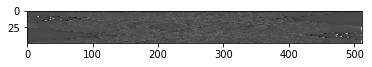

Epoch: 0 - 0 - mse 0.114889: 
Epoch: 1 - 0 - mse 0.114670: 
Epoch: 2 - 0 - mse 0.114449: 
Epoch: 3 - 0 - mse 0.114228: 
Epoch: 4 - 0 - mse 0.114006: 
Epoch: 5 - 0 - mse 0.113783: 
Epoch: 6 - 0 - mse 0.113559: 
Epoch: 7 - 0 - mse 0.113335: 
Epoch: 8 - 0 - mse 0.113109: 
Epoch: 9 - 0 - mse 0.112883: 
Epoch: 10 - 0 - mse 0.112656: 
Epoch: 11 - 0 - mse 0.112428: 
Epoch: 12 - 0 - mse 0.112199: 
Epoch: 13 - 0 - mse 0.111969: 
Epoch: 14 - 0 - mse 0.111739: 
Epoch: 15 - 0 - mse 0.111508: 
Epoch: 16 - 0 - mse 0.111276: 
Epoch: 17 - 0 - mse 0.111042: 
Epoch: 18 - 0 - mse 0.110808: 
Epoch: 19 - 0 - mse 0.110573: 
Epoch: 20 - 0 - mse 0.110338: 
Epoch: 21 - 0 - mse 0.110101: 
Epoch: 22 - 0 - mse 0.109863: 
Epoch: 23 - 0 - mse 0.109625: 
Epoch: 24 - 0 - mse 0.109386: 
Epoch: 25 - 0 - mse 0.109146: 
Epoch: 26 - 0 - mse 0.108905: 
Epoch: 27 - 0 - mse 0.108663: 
Epoch: 28 - 0 - mse 0.108420: 
Epoch: 29 - 0 - mse 0.108175: 
Epoch: 30 - 0 - mse 0.107930: 
Epoch: 31 - 0 - mse 0.107684: 
Epoch: 32 - 0 - ms

In [ ]:
lr = tf.placeholder(dtype=tf.float32, shape=[])  # learning rate
projection_holder = tf.placeholder(dtype=tf.float32, shape=[batch_size, views, width, 1], name='projection_holder')
real_placeholder = tf.placeholder(dtype=tf.float32, shape=[batch_size, width, width, 1], name='real_placeholder')
with tf.variable_scope('generator_model', reuse=tf.AUTO_REUSE) as scope_generator_model:
    Gz = generator(projection_holder)
    mse = tf.reduce_mean(tf.squared_difference(Gz, real_placeholder))
    gen_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator_model')
    g_trainer = tf.train.AdamOptimizer(learning_rate=lr).minimize(mse, var_list=gen_variables)
Patient_IDs = 'L143'
saver = tf.train.Saver()
print("enter Session")
sess.run(tf.global_variables_initializer())
#saver.restore(sess, '/content/gdrive/My Drive/hands_on3/model_dm/SIGmathmodel100.ckpt')
print('model restored')
print("Begin training")
filename = "/content/gdrive/My Drive/hands_on3/" + str(Patient_IDs) + ".h5"
label = read_data(filename)
batch_label = np.expand_dims(np.expand_dims(np.squeeze(label[0,:,:,:]), 0), -1)
batch_data = get_sino(batch_label)
plt.imshow(np.squeeze(batch_data), cmap='gray')
plt.show()

for iteration in range(num_epoch):
    #break
    val_lr = learning_rate / 1
    for i in range(1):
        _mse, _ = sess.run([mse, g_trainer], feed_dict={real_placeholder: (batch_label),
                                                                             projection_holder: (batch_data), lr: val_lr})

        print('Epoch: %d - %d - mse %.6f: ' % (iteration, i, _mse))

saver.save(sess, '/content/gdrive/My Drive/hands_on3/model_dm/SIGmathmodel100.ckpt')
  
print("testing dataset")
for c in range(1):
    test_img = np.squeeze(label[c * 1: (c + 1) * 1])
    test_img = np.expand_dims(test_img, 0)
    test_img = np.expand_dims(test_img, -1)
    test_sino = get_sino(test_img)
    with tf.variable_scope('generator_model') as scope:
        scope.reuse_variables()
        estimated = sess.run(Gz, feed_dict={projection_holder: test_sino})
        t_r = np.squeeze(test_img[i])
        e_1 = np.squeeze(estimated[i])
        f_n = '/content/gdrive/My Drive/hands_on3/direct_map/' + str(c) + str(i) + 'validation.jpg'
        plt.imsave(f_n, e_1, cmap='gray')
        f_n = '/content/gdrive/My Drive/hands_on3/direct_map/' + str(c) + str(i) + 'real_.jpg'
        plt.imsave(f_n, t_r, cmap='gray')

        z = (t_r - e_1) ** 2
        print(np.mean(z))

